<a href="https://colab.research.google.com/github/masud1901/All-in-one-classification-model/blob/main/Custom_ResNet_with_bloodcell_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Connecting Kaggle to Colab**

In [2]:
!mkdir -p ~/.kaggle
!cp "/content/gdrive/My Drive/kaggleJson/kaggle.json" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Downloading the dataset

In [3]:
! kaggle datasets download -d paultimothymooney/blood-cells
!unzip blood-cells.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8050.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8167.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8283.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8324.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8379.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8577.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8587.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8655.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8701.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_872.jpeg  
  inflating: dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_9_8864.jpeg  
  inflating: dataset2-mast

Making a smaller dataset for ResNet to work on

In [4]:
# import os
# import shutil
# import random

# # Define the directories
# main_dataset_dir = '/content/dataset2-master/dataset2-master/images'
# small_dataset_dir = '/content/fruits-360-small'

# # Define the subdirectories
# sub_dirs = ['Training', 'Test']

# # For each subdirectory (Training and Test)
# for sub_dir in sub_dirs:
#     # Get the list of all classes in the main dataset
#     all_classes = os.listdir(os.path.join(main_dataset_dir, sub_dir))

#     # Randomly select 10 classes
#     selected_classes = random.sample(all_classes, 20)

#     # Create the corresponding subdirectory in the small dataset directory if it doesn't exist
#     os.makedirs(os.path.join(small_dataset_dir, sub_dir), exist_ok=True)

#     # Copy the selected classes to the small dataset directory
#     for class_name in selected_classes:
#         shutil.copytree(os.path.join(main_dataset_dir, sub_dir, class_name), os.path.join(small_dataset_dir, sub_dir, class_name))


importing the required libraries

In [5]:
from tensorflow.keras.layers import Input,Lambda, Dense, Flatten, \
  Conv2D,BatchNormalization, ZeroPadding2D, MaxPooling2D , Activation, add
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

In [6]:
#re-sizing all images to this size
IMAGE_SIZE = [224,224]

#training config
epochs = 5
batch_size= 64

In [7]:
train_path = '/content/dataset2-master/dataset2-master/images/TRAIN'
val_path = '/content/dataset2-master/dataset2-master/images/TEST'

# train_path = '/content/fruits-360_dataset/fruits-360/Training'
# val_path = '/content/fruits-360_dataset/fruits-360/Test'

# useful for getting the number of files
image_files = glob(train_path + '/*/*.jp*g')
val_image_files = glob(val_path + '/*/*.jp*g')

# useful for getting number of classes
folders = glob(train_path + '/*')

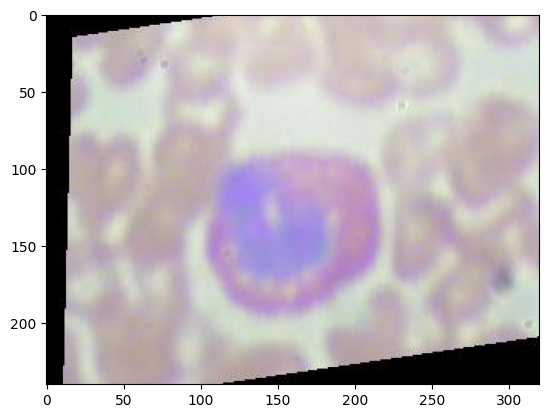

In [8]:
# looking at a random image

plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

Making the custom ResNet model

In [9]:
def identity_block(input_,kernel_size,filters):
  f1,f2,f3 = filters

  x = Conv2D(f1,(1,1)
              #  kernel_initializer= 'he_normal'
             )(input_)
  x= BatchNormalization()(x)
  x= Activation('relu')(x)

  x = Conv2D(f2,kernel_size,padding='same',
              #  kernel_initializer= 'he_normal'
             )(x)
  x= BatchNormalization()(x)
  x= Activation('relu')(x)

  x = Conv2D(f3,(1,1),
              #  kernel_initializer= 'he_normal'
             )(x)
  x= BatchNormalization()(x)

  x = add([x,input_])
  x = Activation('relu') (x)

  return x

In [10]:
def conv_block(input_,kernel_size,filters,strides=(2,2)):
  f1,f2,f3 = filters

  x = Conv2D(f1,(1,1)
              #  kernel_initializer= 'he_normal'
             )(input_)
  x= BatchNormalization()(x)
  x= Activation('relu')(x)

  x = Conv2D(f2,kernel_size,padding='same',
              #  kernel_initializer= 'he_normal'
             )(x)
  x= BatchNormalization()(x)
  x= Activation('relu')(x)

  x = Conv2D(f3,(1,1),
              #  kernel_initializer= 'he_normal'
             )(x)
  x= BatchNormalization()(x)

  shortcut =  Conv2D(f3,(1,1),strides=strides,
              #  kernel_initializer= 'he_normal'
             )(input_)
  shortcut= BatchNormalization()(shortcut)

  x = add([x,shortcut])
  x = Activation('relu') (x)

  return x

The custom ResNet

In [11]:
# our custom resnet
i = Input(shape = IMAGE_SIZE + [3])
x = ZeroPadding2D(padding=(3,3)) (i)
x = Conv2D(64, (7,7),
           strides=(2,2),
           padding='valid',
          #  kernel_initializer='he_normal'
           ) (x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = ZeroPadding2D(padding=(1,1)) (x)
x = MaxPooling2D((3,3),strides=(2,2))(x)

x = conv_block(x, 3,[64,64,256],strides=(1,1))
x = identity_block(x,3,[64,64,256])
x = identity_block(x,3,[64,64,256])

x = conv_block(x, 3,[128,128,512],strides=(1,1))
x = identity_block(x,3,[128,128,512])
x = identity_block(x,3,[128,128,512])
x = identity_block(x,3,[128,128,512])

x = Flatten()(x)
prediction = Dense(len(folders),activation = 'softmax')(x)

model = Model(inputs = i,outputs = prediction)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         9472      ['zero_padding2d[0][0]']      
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 64)         256       ['conv2d[0][0]']          

In [12]:
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = Adam(learning_rate=0.001),
    metrics = ['accuracy']
)

**Creating the Image to feed into the vgg16**

In [13]:
#create an instance of ImageDataGenerator
def preprocess_input2(x):
  x /=127.5
  x -=1.
  return x



train_gen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input2
)

val_gen = ImageDataGenerator(
    preprocessing_function = preprocess_input2
)

Found 2487 images belonging to 4 classes.
{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}
min: -1.0 max: 1.0


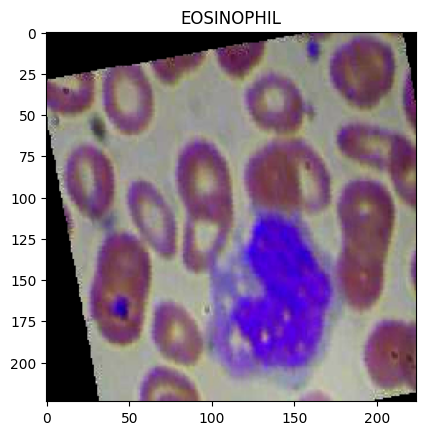

In [14]:
# testing the generator to see how it works and some other usefull things

# get label mapped for confusion matrix plot later
test_gen = val_gen.flow_from_directory(val_path, target_size = IMAGE_SIZE,class_mode='sparse')
print(test_gen.class_indices)
labels = [None]* len(test_gen.class_indices)
for k,v in test_gen.class_indices.items():
  labels[v]=k

# should be strangely colored image (sue to VGG weights being BGR)
for x,y in test_gen:
  print("min:",x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[1])
  plt.show()
  break


In [15]:
#create generator

train_generator = train_gen.flow_from_directory(
    train_path,
    target_size = IMAGE_SIZE,
    shuffle = True,
    batch_size = batch_size,
    class_mode = 'sparse'
)

val_generator = val_gen.flow_from_directory(
    val_path,
    target_size = IMAGE_SIZE,
    shuffle = True,
    batch_size = batch_size,
    class_mode = 'sparse'
)

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [16]:
# fit the model

checkpoint_filepath = '/content/checkpoint'

r = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=len(image_files) // batch_size,
    validation_steps=len(val_image_files) // batch_size,
    verbose=1,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor = 'loss',patience = 3, restore_best_weights=True
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath = checkpoint_filepath,
            save_weights_only = True,
            monitor = 'val_accuracy',
            mode = 'max',
            save_best_only = True
        )
    ]
)

Epoch 1/10
155/155 [==============================] - 230s 1s/step - loss: 56.0601 - accuracy: 0.3375 - val_loss: 2.7727 - val_accuracy: 0.2525
Epoch 2/10
155/155 [==============================] - 195s 1s/step - loss: 1.2988 - accuracy: 0.5905 - val_loss: 3.1332 - val_accuracy: 0.2607
Epoch 3/10
155/155 [==============================] - 196s 1s/step - loss: 0.6518 - accuracy: 0.7538 - val_loss: 1.3584 - val_accuracy: 0.5670
Epoch 4/10
155/155 [==============================] - 190s 1s/step - loss: 0.3373 - accuracy: 0.8802 - val_loss: 4.4003 - val_accuracy: 0.5325
Epoch 5/10
155/155 [==============================] - 192s 1s/step - loss: 0.3416 - accuracy: 0.8802 - val_loss: 0.7164 - val_accuracy: 0.7109
Epoch 6/10
155/155 [==============================] - 204s 1s/step - loss: 0.2228 - accuracy: 0.9225 - val_loss: 1.4276 - val_accuracy: 0.6768
Epoch 7/10
155/155 [==============================] - 186s 1s/step - loss: 0.2216 - accuracy: 0.9229 - val_loss: 0.9871 - val_accuracy: 0.802

In [19]:
# making a confusion matrix

def get_confusion_matrix(data_path,N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix" , N)
  predictions = []
  targets = []
  i = 0
  for x,y in val_gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle = False, batch_size=batch_size*2):
    i+=1
    if i%50 ==0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis =1)
    y = np.argmax(y, axis = 1)
    predictions = np.concatenate((predictions,p))
    targets = np.concatenate((targets,y))
    if len(targets)>=N:
      break

  cm = confusion_matrix(targets,predictions)
  return cm


In [ ]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)

In [ ]:
val_cm = get_confusion_matrix(val_path, len(image_files))
print(val_cm)

Plotting some data

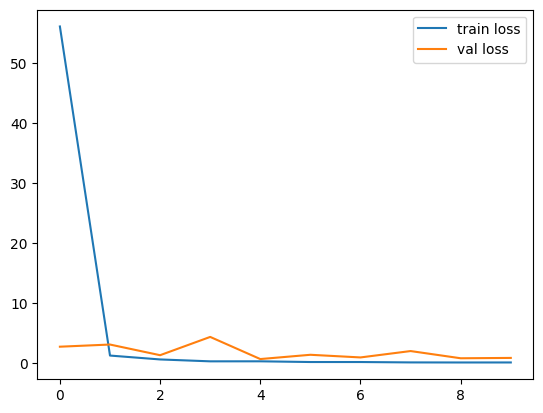

In [22]:
#loss

plt.plot(r.history['loss'],label = 'train loss')
plt.plot(r.history['val_loss'],label = 'val loss')
plt.legend()
plt.show()

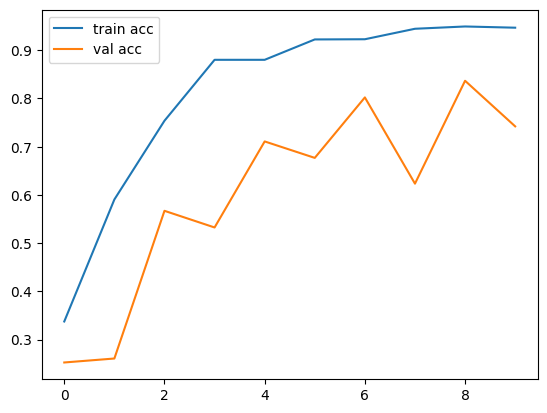

In [23]:
# acccuracy

plt.plot(r.history['accuracy'],label = 'train acc')
plt.plot(r.history['val_accuracy'],label = 'val acc')
plt.legend()
plt.show()


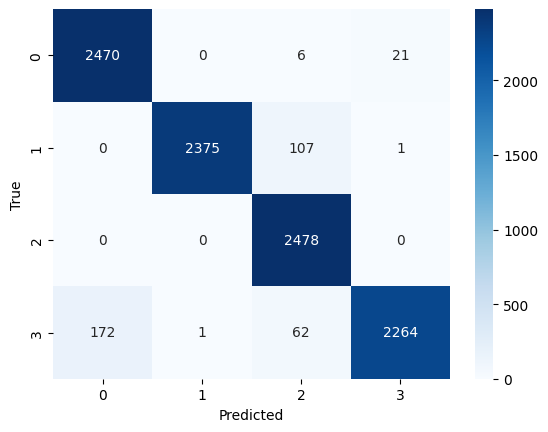

In [26]:
# visualising training cm
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

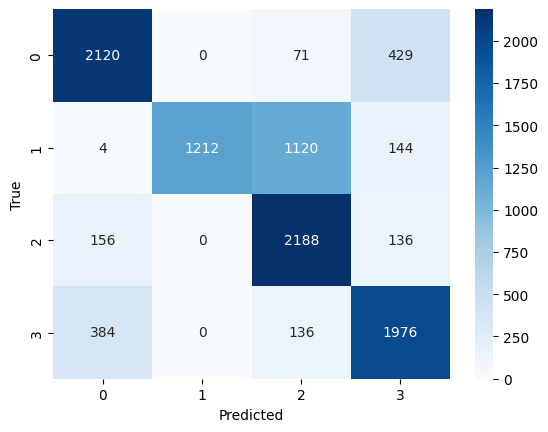

In [27]:
# visualising validation cm
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [28]:
model.load_weights(checkpoint_filepath)

In [30]:
np.trace(cm) /cm.sum()

0.9628402129155368

In [32]:
np.trace(val_cm) /val_cm.sum()

0.7439460103215562